<a href="https://colab.research.google.com/github/marino1846067/CMP2021/blob/main/7_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREAMBLE

We will look at how to run MCMCs on data using:
1. **emcee** – a pure-Python implementation of an Markov chain Monte Carlo (MCMC) ensemble sampler (to be specific: Goodman & Weare’s Affine Invariant Markov chain Monte Carlo Ensemble sampler)
1. **pymc** – (formerly PyMC3) is a Python package for Bayesian statistical modeling focusing on advanced MCMC and variational inference algorithms. Its flexibility and extensibility make it applicable to a large suite of problems. 

When a package is missing, this is how you can install it (on Colab, or machines supplied with `pip`)

In [ ]:
!pip install emcee

     |████████████████████████████████| 45 kB 1.9 MB/s 


In [ ]:
!pip install pymc

     |████████████████████████████████| 385 kB 5.1 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353140 sha256=65061330a7239f4eb3f65241e315bf3d0a163d902c642fa4a8bc1375b1400b8c
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import emcee
import pymc

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# EMCEE

## Let's cook up some data to analyze

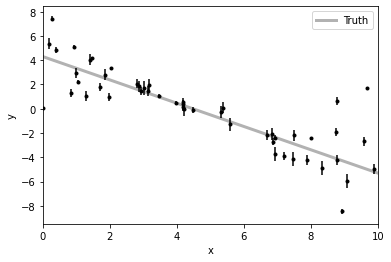

In [ ]:
# Let's fix the seed to make the random numbers reproducible
np.random.seed(1)

# Specify "truth": y = mx + q
m_true = -0.9594
q_true = 4.294
true_dict = {'m': m_true, 'q': q_true}

# Specify an amplitude for Gaussian noise
f_true = 0.534

# Generate some synthetic data from the "truth"
N = 50
x = np.sort(10 * np.random.rand(N))
y = m_true * x + q_true
# Generate the QUOTED (Gaussian) uncertainties on such data
yerr = 0.1 + 0.5 * np.random.rand(N)
# and polute the y's with these errors
y += yerr * np.random.randn(N)
# Ensure that these uncertainties understimate the actual ones
# by a constant fractional amount f_true * gaussian noise
y += np.abs(f_true * y) * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + q_true, "k", alpha=0.3, lw=3, label="Truth")
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## Least-squared fit with `scipy.optimize.curve_fit`

In [ ]:
def fitfunc(x, m, q):
    return m*x + q

param_labels = ['m', 'q']

fit_pars, cov_matrix = curve_fit(fitfunc, x, y, sigma=yerr)

for i in range(len(param_labels)):
    print("{0: .1f}% error on parameter {1}".format(np.abs(100*cov_matrix[i, i]**0.5/fit_pars[i]), param_labels[i]))
    print("{0: .4f} +/-{1: .4f} (true value {2})".format(fit_pars[i], cov_matrix[i, i]**0.5, true_dict[param_labels[i]]))

 19.9% error on parameter m
-0.5222 +/- 0.1038 (true value -0.9594)
 17.4% error on parameter q
 3.1797 +/- 0.5547 (true value 4.294)


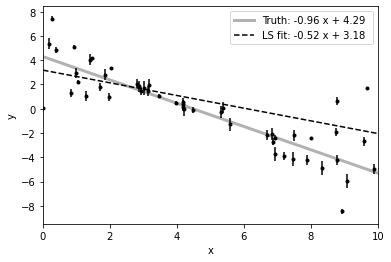

In [ ]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + q_true, "k", alpha=0.3, lw=3, label="Truth: %.2f x + %.2f " % (m_true, q_true))
plt.plot(x0, fitfunc(x0, *fit_pars), '--k', label="LS fit: %.2f x + %.2f" % tuple(fit_pars))
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

The result is reasonable (notice how the cluster of data points affects it), but the uncertainties on the two parameters are small, because of the small error bars on most of the data points.

## Maximum likelihood estimation

The least squares solution is the maximum likelihood result for a model where the error bars are assumed correct, Gaussian and independent. But this is not the right model.  Additionally, there is no generalization of least squares that supports a model like the one that we know to be true. Instead, we need to write down the likelihood function and numerically optimize it.

emcee uses logarithms of probability densities, so we focus on the log-likelihood and write out a Gaussian with variance is underestimated by some fractional amount $f$:
$$
\ln \mathcal{L}(\mathbf{d}|\boldsymbol{\theta}) = \ln p(\mathbf{x}, \mathbf{y}, \boldsymbol{\sigma}| m,q,f) = -{1\over 2}\sum_k\left[ {{(y_k - mx_k - q)^2}\over {s_k^2}} + \ln (2\pi s_k^2)\right]
$$
with
$$
s_k^2 = \sigma_k^2 + f^2(mx_k + q)^2\,.
$$

[Note that we can think of $\mathbf{x}$ and $\boldsymbol{\sigma}$ as information $\mathcal{I}$ here and write $\ln \mathcal{L}(\mathbf{d}|\boldsymbol{\theta}, \mathcal{I}) = \ln p(\mathbf{y}| \mathbf{x},  \boldsymbol{\sigma}, m,q,f)$.]


We build the log-likelihood Python function [see later for why $\ln f$ rather than $f$ is used as a variable].

In [ ]:
def log_likelihood(theta, x, y, yerr):
    m, q, log_f = theta
    model = m * x + q
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

We minimize $-\ln\mathcal{L}(\mathbf{d}|\boldsymbol{\theta})$ with `scipy.optimize.minimize`

False
Desired error not necessarily achieved due to precision loss.
Maximum likelihood estimates:
m = -0.9440 (True: -0.9594)
q = 4.2449 (True: 4.2940)
f = 0.5055 (True: 0.5340)


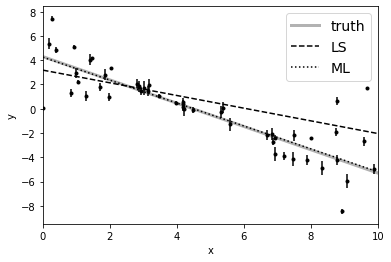

In [ ]:
from scipy.optimize import minimize

# Reproducible results
np.random.seed(42)

# Function to minimize
nll = lambda *args: -log_likelihood(*args)

# Initial guess for the parameters (make it imperfect with Gaussian noise)
initial = np.array([m_true, q_true, np.log(f_true)]) + 0.1 * np.random.randn(3)

# Solve by minimization of -log-likelihood!
soln = minimize(nll, initial, args=(x, y, yerr))

# Check it converged
print(soln.success)
print(soln.message)

# Extract maximum likelihood parameter values
m_ml, q_ml, log_f_ml = soln.x
print("Maximum likelihood estimates:")
print("m = {0:.4f} (True: {1:.4f})".format(m_ml, m_true))
print("q = {0:.4f} (True: {1:.4f})".format(q_ml, q_true))
print("f = {0:.4f} (True: {1:.4f})".format(np.exp(log_f_ml), f_true))

# Plot all together
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + q_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, fitfunc(x0, *fit_pars), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, q_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Much better, but how do we estimate the uncertainties on m and q?


Also, we do not really care much about the value of $f$ but it seems to propagate any uncertainties about its value to the final estimates of $m$ and $q$.

**This is where MCMC comes in.**



## MCMC estimation of model parameters via emcee

We would like to
1. be able to marginalize over "**nuisance parameters**" ($f$ in the example) and 
1. to find an estimate of the posterior probability function, i.e., the distribution of parameters that is consistent with the dataset, for the other parameters, i.e., the **model parameters**.

MCMC lets you do both of these things.

### 1. Set up the calculation
Let's write the **posterior probability distribution** in general terms:

$$
p(\boldsymbol{\theta}|\mathbf{d}) \propto \pi(\boldsymbol{\theta}) \mathcal{L}(\mathbf{d}|\boldsymbol{\theta})\,,
$$

where $\pi$ denotes the **prior probability distribution**.  For the case we are examining,

$$
p(m,q,f|\mathbf{x}, \mathbf{y}, \boldsymbol{\sigma}) \propto \pi(m,q,f)\mathcal{L}(\mathbf{x}, \mathbf{y}, \boldsymbol{\sigma}|m,q,f)\,.
$$

We have already written down the likelihood function, so what we are missing is the prior $p(m,q,f)$.  This function encodes any previous knowledge that we have about the parameters (e.g., results from other experiments, physically acceptable ranges, etc.).

The MCMC draws samples from a probability distribution.  We want that distribution to be a probability distribution for the parameters of interest, i.e., $\pi \times \mathcal{L}$.  For each draw, the likelihood will be evaluated and the product of the prior and likelihood yields the posterior (up to a constant, which is the **evidence**).

Let's pick a uniform, "uninformative" prior on $m$, $q$, and $\ln f$:

$$
p(m) =
\begin{cases}
1/5.5, & \textrm{if} −5<m<1/2\\
0 & \textrm{otherwise}
\end{cases}
$$
and similar ones for the other two parameters.

emcee requires the logarithm of the probability density one wants to sample, so here is the Python log-prior (up to a constant):

In [ ]:
def log_prior(theta):
    m, q, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < q < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

Combining this with the definition of `log_likelihood` we had above, the full log-probability function is:

In [ ]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

### 2. Run the sampler

Now it is straightforward to sample this distribution using emcee.

Start by initializing the (32) walkers in a tiny Gaussian ball around the maximum likelihood result: this tends to be a pretty good initialization.

Then perform the (5000) steps of MCMC.

In [ ]:
# The number of walkers
nwalkers = 32

# The dimensionality of the parameter space (m, q, ln(f))
ndim = 3

# The MCMC steps
nmcmc = 5000

# Initial position
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, nmcmc, progress=True); # The ; avoids some prints to screen

100%|██████████| 5000/5000 [00:08<00:00, 610.08it/s]


### 3. Look at results

To see what the sampler did, a good first step is to look at the time series of the parameters in the chain.  The samples can be accessed using the `EnsembleSampler.get_chain()` method.  This returns an array with the shape `(nmcmc, nwalkers, ndim)`, providing the parameter values for each walker at each step in the chain.

Text(0.5, 0, 'MCMC step')

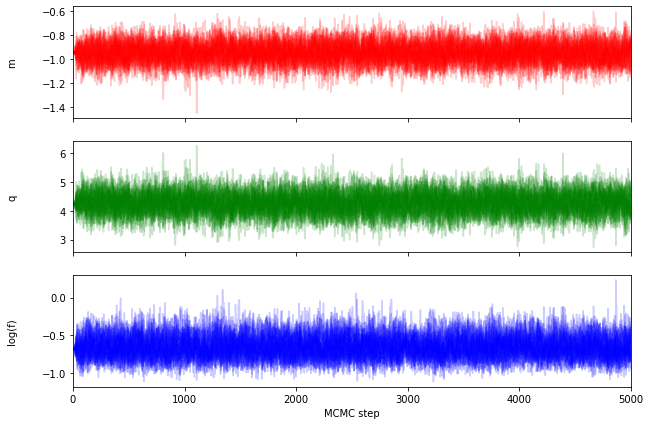

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "q", "log(f)"]
col = ['r', 'g', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step")

The walkers start in small distributions around the maximum (log-)likelihood values and then wander and start exploring the full posterior distribution.

After fewer than 50 steps, the samples seem pretty well “burnt-in.”  It is hard to define this statement quantitatively, but an estimate of the integrated autocorrelation time

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

[37.04821237 37.96445457 39.81580932]


suggests that $\sim 40$ steps are needed for the chain to “forget” where it started.  It is reasonable to throw away a few times this number of steps as “burn-in."

Let’s discard the initial 100 steps, *thin* (i.e., take strides) by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


Now let’s make a [**corner plot**](https://corner.readthedocs.io/en/latest/), one of the most useful plots related to MCMC calculations:

In [ ]:
!pip install corner

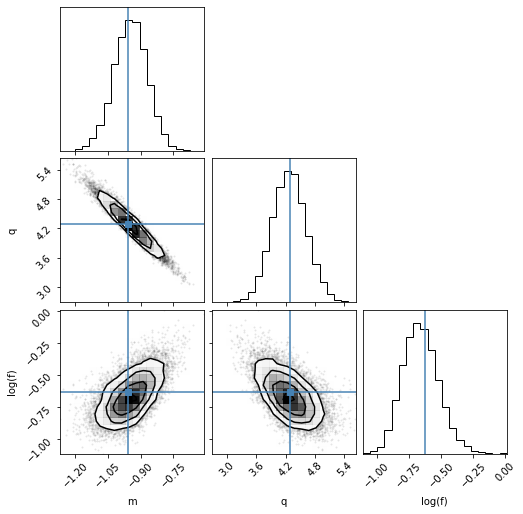

In [ ]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=[m_true, q_true, np.log(f_true)])

These are **all the one and two dimensional projections of the posterior probability distributions** of the parameters we are inferring.  It quickly shows all of the covariances between parameters.

To find the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain, one projects the samples into the sub-space of interest and then makes an histogram over it.  Corner plots are doing this in all possibile 2D and 1D sub-spaces.

Another diagnostic plot is the projection of the results into the space of the observed data. Choose a few (say 100 in this case) samples from the chain and plot them on top of the data points:

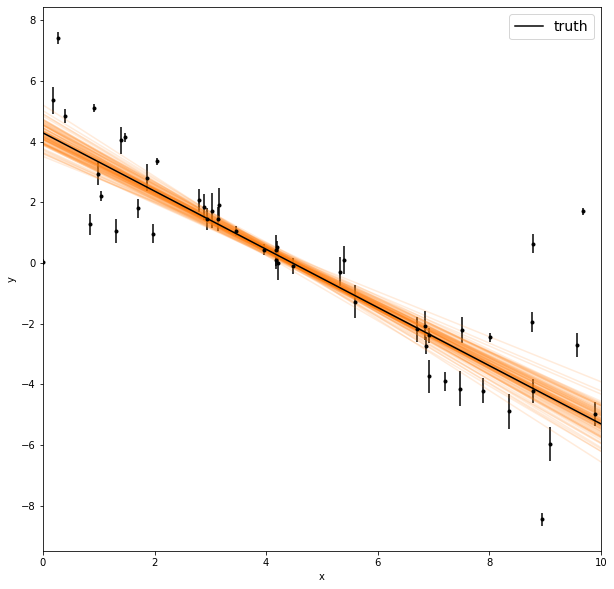

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)

fig = plt.figure(figsize=(10,10))
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.15)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + q_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Last but not least, the parameter values and their **credible intervals**.

Say you decide to quote the 90% credible intervals, with the median value.  You need the 5th, 50th, and 95th percentile of the samples in the marginalized distributions:

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    interval = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], interval[0], interval[1], labels[i])
    display(Math(txt))

print("As a reminder, true values:")
print("True m = {0:.4f}".format(m_true))
print("True q = {0:.4f}".format(q_true))
print("True log(f) = {0:.4f}\n".format(np.log(f_true)))

print("As a reminder, maximum likelihood estimates:")
print("m = {0:.4f}".format(m_ml))
print("q = {0:.4f}".format(q_ml))
print("f = {0:.4f}\n".format(log_f_ml))

print("As a reminder, least-squares values:")
print("m = {0: .4f} +/-{1: .4f} ".format(fit_pars[0], cov_matrix[0, 0]**0.5))
print("q = {0: .4f} +/-{1: .4f}".format(fit_pars[1], cov_matrix[1, 1]**0.5))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

As a reminder, true values:
True m = -0.9594
True q = 4.2940
True log(f) = -0.6274

As a reminder, maximum likelihood estimates:
m = -0.9440
q = 4.2449
f = -0.6823

As a reminder, least-squares values:
m = -0.5222 +/- 0.1038 
q =  3.1797 +/- 0.5547


# PYMC

## Example 1: revisiting the linear model case with PyMC

As with emcee, we will have to
1. set up the calculation (i.e., the inference model)
1. run the sampler
1. look at its results

The PyMC model is defined solely in terms of objects referred to as `stochastic`'**s** (in the Bayesian sense, they are random variables). The three parameters are given uniform priors (other, more complicated priors could be used).

Note how in setting up the model we can rely on distributions provided by PyMC: in most cases, we can avoiding writing our Python function for the prior(s).

In [ ]:
# Define the parameters with their associated priors
m = pymc.Uniform('m', -5, 0.5, value=soln.x[0])
q = pymc.Uniform('q', 0, 10, value=soln.x[1])
logf = pymc.Uniform('log(f)', -100, 1, value=soln.x[2])

We then define the model as a Python function with a special **decorator**: `pymc.deterministic`.  This tells PyMC that `model` is a function that depends on stochastic objects, but is itself a deterministic function of them (it is a function of random variables, not a random variable itself).

In [ ]:
# Now define the model
@pymc.deterministic
def model(m=m, q=q, x=x):
    return q + m*x

The same is true for the function `tau` that simply converts the (augmented) standard deviation parameter into a precision parameter.

In [ ]:
# pymc parametrizes the width of the normal distribution by tau=1/sigma**2
@pymc.deterministic
def tau(yerr=yerr, model=model, logf=logf):
    return np.power(yerr**2 + model**2*np.exp(2 * logf), -1)

The last statement needs to tells PyMC about the data.

Spefically, the next line says that the observed data is drawn from a normal distribution with mean (`mu`) equal to the method `model`, presicsion (`tau`) equal to the method `tau`, and `value` equal to the observed data `y`.  The special argument `observed=True` tells PyMC that this last `stochastic` value should remain constant.

In [ ]:
# Lastly relate the model/parameters to the data
data = pymc.Normal('data', mu=model, tau=tau, value=y, observed=True)

With all the definitions in place, we simply feed the PyMC objects into a `pymc.MCMC` to create a sampler and run it (using the default Metropolis-Hastings algorithm).

In [ ]:
nsampler = 20000
sampler = pymc.MCMC([m, q, logf, model, yerr, y, x])
sampler.sample(iter=nsampler)

 [-----------------100%-----------------] 20000 of 20000 complete in 4.6 sec

Time to look at the results!

Plotting q
Plotting m
Plotting log(f)


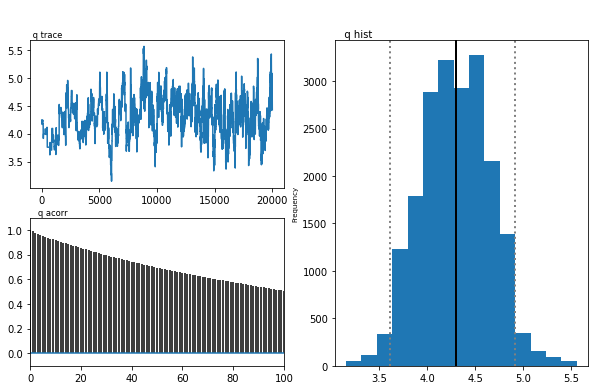

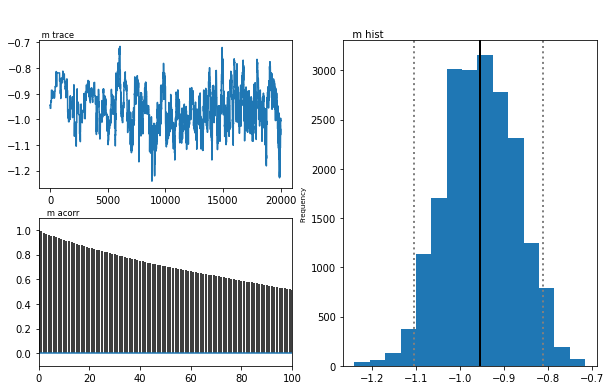

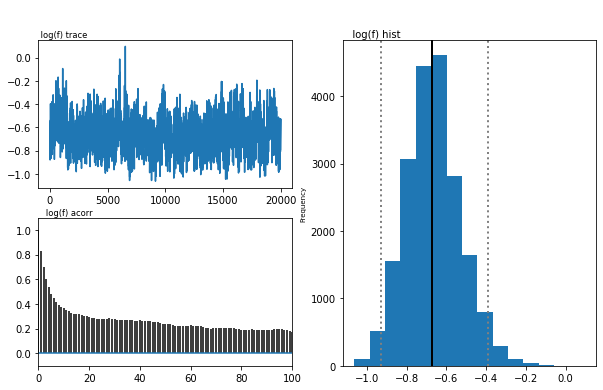

In [ ]:
pymc.Matplot.plot(sampler)

For each `stochastic`, PyMC plots the trace (upper-left panel), the auto-correlation (lower-left pane), and the histogram of the samples (right panel).

Now we can do the statistics to find the solution. We print out some summary statistics using PyMC's internals.

In [ ]:
m.summary()
q.summary()


m:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.954           0.08             0.006            [-1.104 -0.811]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-1.105           -1.011          -0.955         -0.895        -0.811
	

q:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	4.303            0.357            0.029              [3.607 4.919]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	3.636            4.049           4.3            4.557         4.977
	


And here is a good old corner plot on PyMC results.

We feed `corner.corner` the chains (`trace`) of each parameter, grouped in a NumPy array and transposed (i.e., an `(nsampler, ndim)` array instead of the original `(ndim, nsampler)` one)

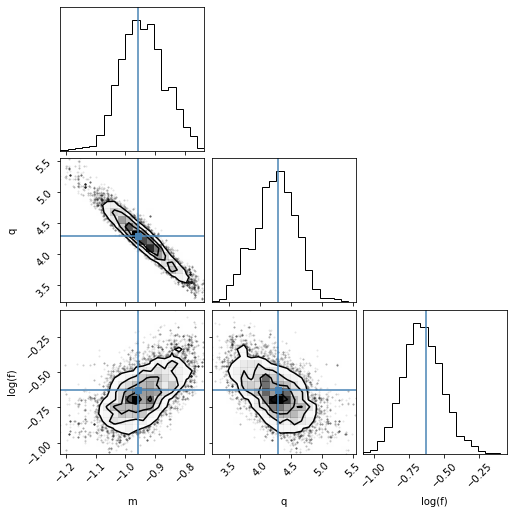

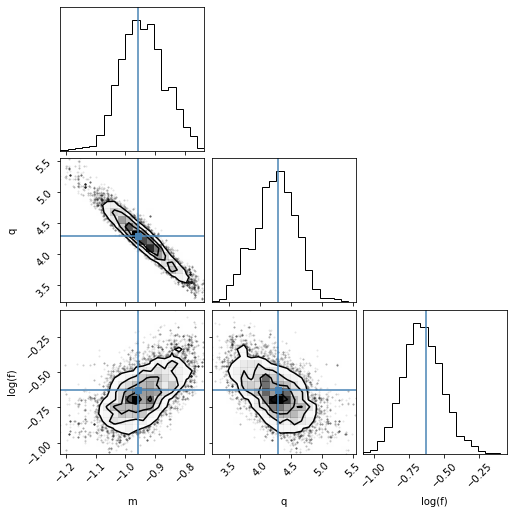

In [ ]:
samples = np.array([m.trace(), q.trace(), logf.trace()]).T
corner.corner(samples[:,:], labels=['m', 'q', 'log(f)'], 
              truths=[m_true, q_true, np.log(f_true)])

## Example 2: a linear regression model with two predictors in PyMC

We start by making some synthetic data.

In this case, we have a linear regression model with two predictor variables $x,y$ and one outcome variable $z$. The relation among them is:
$$
Z_n = \alpha + \beta_x x_n + \beta_y y_n + \epsilon
$$
where $\epsilon$ is a Gaussian noise term.

In [ ]:
Nobs = 20
x_true = np.random.uniform(0, 10, size=Nobs)
y_true = np.random.uniform(-1, 1, size=Nobs)
alpha_true = 0.5
beta_x_true = 1.0
beta_y_true = 10.0
eps_true = 0.5
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true
z_obs = z_true + np.random.normal(0, eps_true, size=Nobs)

2D plots of our 3D data

Text(0, 0.5, 'y')

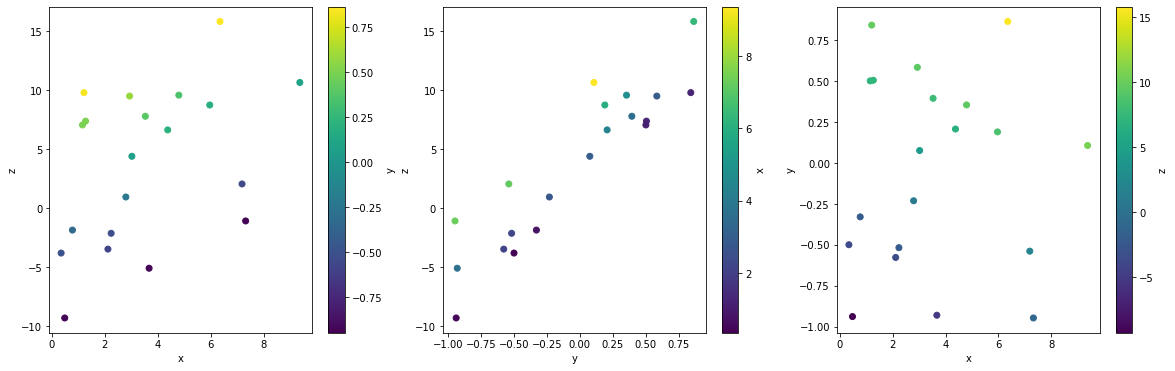

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(x_true, z_obs, c=y_true, marker='o')
plt.colorbar(label='y')
plt.xlabel('x')
plt.ylabel('z')
plt.subplot(1,3,2)
plt.scatter(y_true, z_obs, c=x_true, marker='o')
plt.colorbar(label='x')
plt.xlabel('y')
plt.ylabel('z')
plt.subplot(1,3,3)
plt.scatter(x_true, y_true, c=z_obs, marker='o')
plt.colorbar(label='z')
plt.xlabel('x')
plt.ylabel('y')

As a reminder, we have to:
1. set up the calculation (i.e., the inference model)
1. run the sampler
1. look at its results

In [ ]:
# Define the 4 parameters with their associated priors
alpha = pymc.Uniform('alpha', -100, 100, value=np.median(z_obs))
betax = pymc.Uniform('betax', -100, 100, value=np.std(z_obs)/np.std(x_true))
betay = pymc.Uniform('betay', -100, 100, value=np.std(z_obs)/np.std(y_true))
eps = pymc.Uniform('eps', 0, 100, value=0.01)

# Now define the model
@pymc.deterministic
def model(alpha=alpha, betax=betax, betay=betay, x=x_true, y=y_true):
    return alpha + betax*x + betay*y

# pymc parametrizes the width of the normal distribution by tau=1/sigma**2
@pymc.deterministic
def tau(eps=eps):
    return np.power(eps, -2)

# Lastly relate the model/parameters to the data
data = pymc.Normal('data', mu=model, tau=tau, value=z_obs, observed=True)

The last statement tells PyMC that the observed data `z_obs` is drawn from a normal distribution with mean equal to the model, presicsion equal to $1/\epsilon ^2$ and value equal to the observed data. `observed=True` argument tells PyMC that this `stochastic` value should remain constant.

In [ ]:
# Run the sampler
nsampler = 20000
sampler = pymc.MCMC([alpha, betax, betay, eps, model, tau, z_obs, x_true, y_true])
sampler.sample(iter=nsampler)

 [-----------------100%-----------------] 20000 of 20000 complete in 4.7 sec

Results!

Plotting alpha
Plotting tau
Plotting eps
Plotting betax
Plotting betay


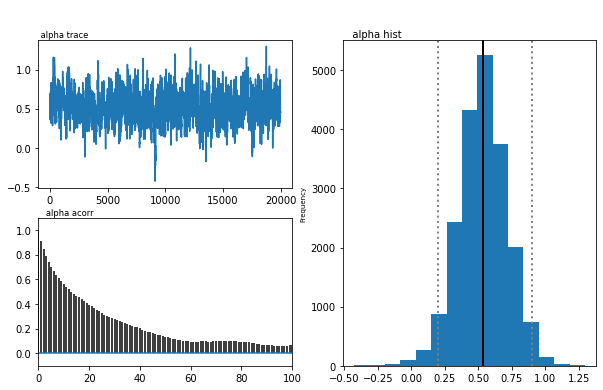

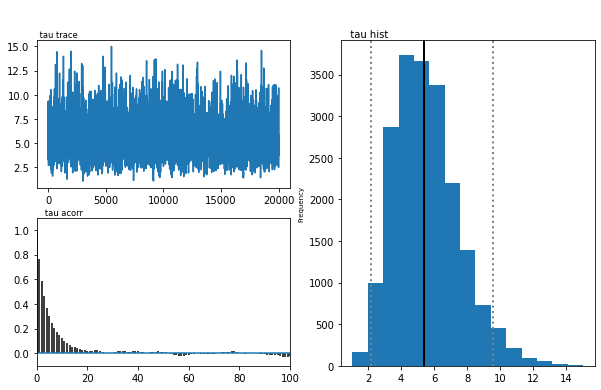

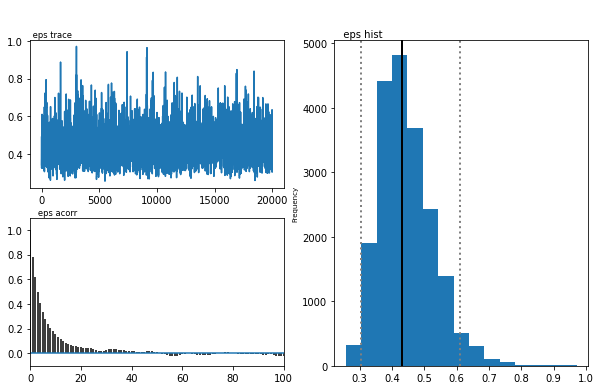

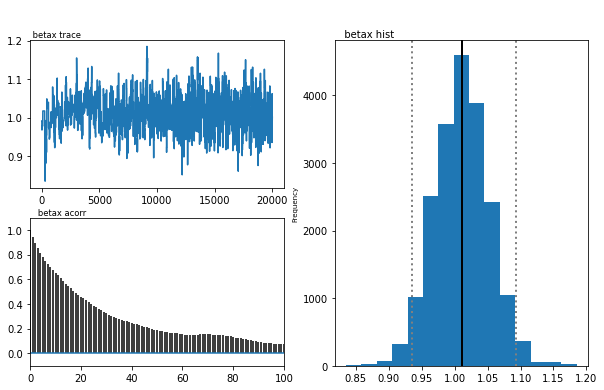

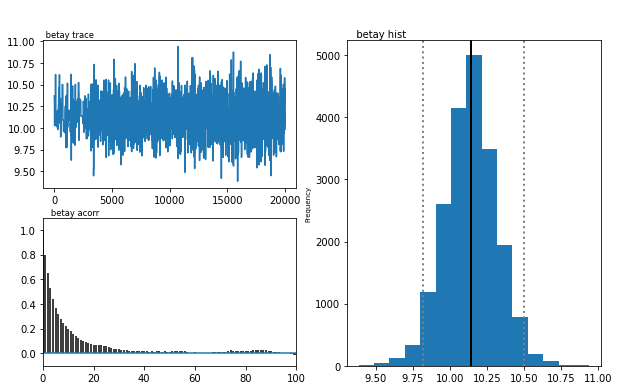

In [ ]:
pymc.Matplot.plot(sampler)

In [ ]:
alpha.summary()
betax.summary()
betay.summary()
eps.summary()


alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.534            0.182            0.008              [0.2   0.901]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.175            0.422           0.533          0.653         0.882
	

betax:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.011            0.041            0.002              [0.936 1.093]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.932            0.984           1.012          1.04          1.092
	

betay:
 
	Mean             SD               MC Error        95% HPD interval
	---------------------

Let's get the median of each variable from the samples; the median is more robust toward non-symmetric distributions (such as the one for eps). We get at the MCMC samples by looking at each variable's trace.  

In [ ]:
m_alpha = np.median(alpha.trace())
m_betax = np.median(betax.trace())
m_betay = np.median(betay.trace())
m_eps = np.median(eps.trace()) 

Now we can plot the results, correcting for the $y$ predictor when plotting versus $x$ and vice versa. This way we can make sure the correct trend was recovered.

In [ ]:
x_true

array([6.3509933 , 4.37510653, 1.27193265, 9.3673406 , 2.79353974,
       7.31920974, 1.154511  , 0.34861898, 2.23791912, 2.11634442,
       5.96323041, 3.67147883, 3.52922744, 7.1829008 , 3.02134157,
       2.93476894, 0.48416094, 1.21071997, 4.79470358, 0.77591629])

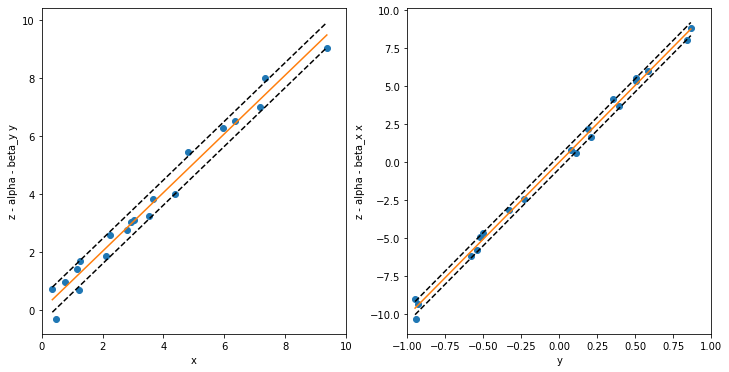

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
# (Corrected) data
plt.plot(x_true, z_obs - m_alpha - m_betay*y_true, 'o')
plt.xlabel('x')
plt.ylabel('z - alpha - beta_y y')
plt.xlim(0,10)
# Model
xx = np.array([x_true.min(), x_true.max()])
plt.plot(xx, xx*m_betax)
plt.plot(xx, xx*m_betax + m_eps, '--', color='k')
plt.plot(xx, xx*m_betax - m_eps, '--', color='k')

plt.subplot(1,2,2)
# (Corrected) data
plt.plot(y_true, z_obs - m_alpha - m_betax*x_true, 'o')
plt.xlabel('y')
plt.ylabel('z - alpha - beta_x x')
plt.xlim(-1,1)
# Model
yy = np.array([y_true.min(), y_true.max()])
plt.plot(yy, yy*m_betay)
plt.plot(yy, yy*m_betay + m_eps, '--', color='k')
plt.plot(yy, yy*m_betay - m_eps, '--', color='k')

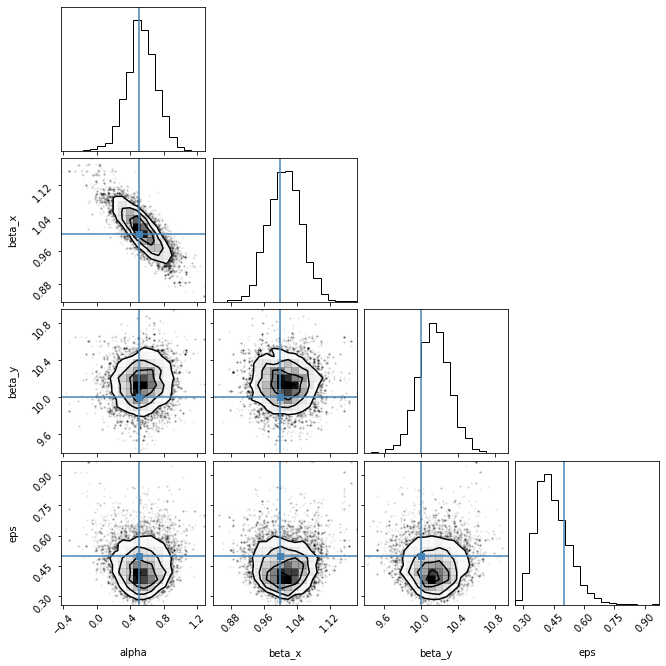

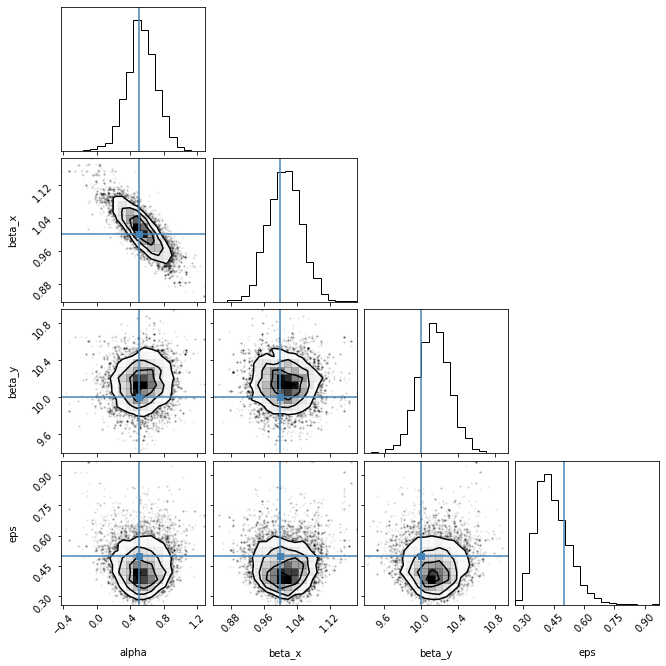

In [ ]:
samples = np.array([alpha.trace(), betax.trace(), betay.trace(), eps.trace()]).T
corner.corner(samples[:,:], labels=['alpha', 'beta_x', 'beta_y','eps'], 
              truths=[alpha_true, beta_x_true, beta_y_true, eps_true])